In [36]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


################################################################
# configs
################################################################
# load data
PATH = "/groups/esm/dzhuang/Catheter/"

INPUT_INFO = PATH+"info_1d_data.npy"
INPUT_X    = PATH+"x_2d_structured_mesh.npy"
INPUT_Y    = PATH+"y_2d_structured_mesh.npy"
OUTPUT     = PATH+"density_1d_data.npy"

ntrain = 800
ntest = 200

batch_size = 20
learning_rate = 0.001

epochs = 501
step_size = 100
gamma = 0.5

modes = 12
width = 32

r1 = 1
r2 = 2
# nx ny
s1 = int(((101 - 1) / r1) + 1)
s2 = int(((401 - 1) / r2) + 1)
s3 = 2001

################################################################
# load data and data normalization
################################################################
dataInfo = np.load(INPUT_INFO)
inputX = np.load(INPUT_X)
inputX = torch.tensor(inputX, dtype=torch.float).permute(2,0,1)
inputY = np.load(INPUT_Y)
inputY = torch.tensor(inputY, dtype=torch.float).permute(2,0,1)
print(inputX.shape, inputY.shape)
input = torch.stack([inputX, inputY], dim=-1)

output = np.load(OUTPUT)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print(input.shape, output.shape)

index = torch.randperm(1000)
train_index = index[:ntrain]
test_index = index[-ntest:]

x_train = input[train_index][:, ::r1, ::r2][:, :s1, :s2]
y_train = output[train_index]
x_test = input[test_index, ::r1, ::r2][:, :s1, :s2]
y_test = output[test_index]
x_train = x_train.reshape(ntrain, s1, s2, 2)
x_test = x_test.reshape(ntest, s1, s2, 2)


################################################################
# training and evaluation
################################################################

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load("catheter_plain_model_100", map_location=device)

print(count_params(model))


torch.Size([1000, 101, 401]) torch.Size([1000, 101, 401])
torch.Size([1000, 101, 401, 2]) torch.Size([1000, 2001])
2384857


rel. error is  0.06433979
rel. error is  0.03660615
rel. error is  0.03408246
rel. error is  0.03300986
rel. error is  0.027636481
rel. error is  0.042781256
rel. error is  0.0584335
rel. error is  0.04261386
rel. error is  0.03321548
rel. error is  0.043228894


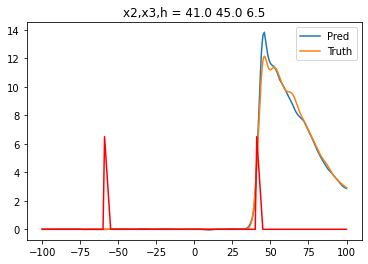

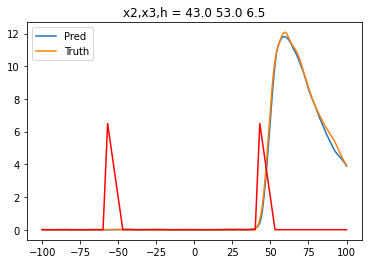

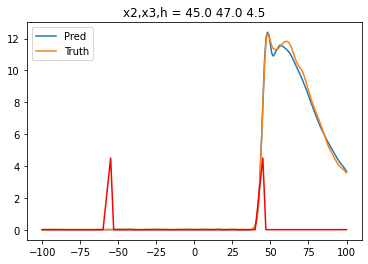

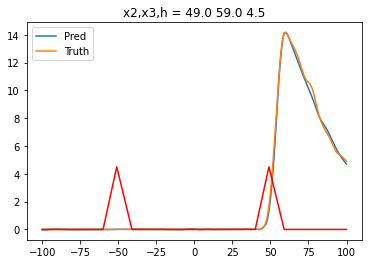

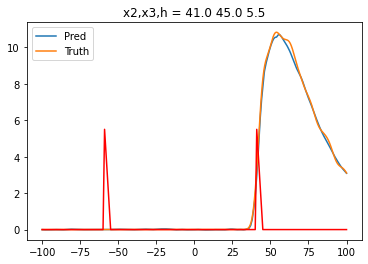

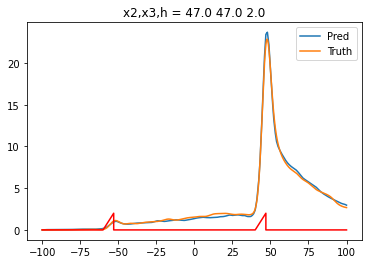

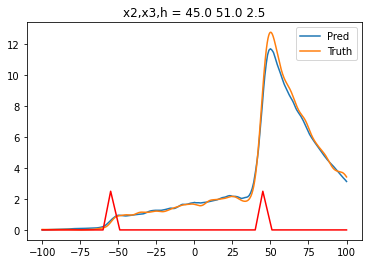

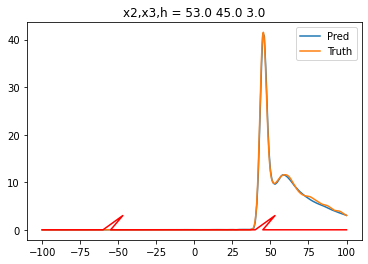

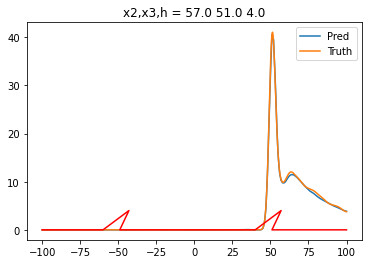

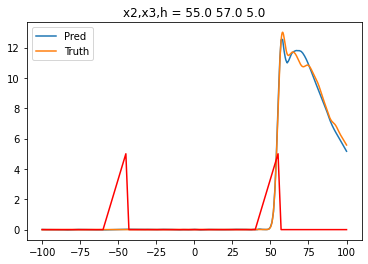

In [48]:


for sample_id in range(0,10):
    sample_test_id = test_index[sample_id].item()
    x2, x3, h, theta1, theta2, p, _ = dataInfo[:, sample_test_id]
    bottom_x, bottom_y = np.array([0-100, 40.0-100, x2-100, x3-100, 0, 40.0, x2, x3, 100.0]),  np.array([0, 0.0, h, 0, 0.0, 0, h, 0, 0.0])

    y_test_pred = model(x_test[sample_id:sample_id+1,:,:,:].to(device)).detach().cpu().numpy().flatten()
    print("rel. error is ", np.linalg.norm(y_test_pred - y_test[sample_id, :].numpy())/np.linalg.norm(y_test[sample_id, :]))
    xx = np.linspace(-100,100,2001)
    plt.figure()
    plt.plot(xx, y_test_pred, label="Pred")
    plt.plot(xx, y_test[sample_id, :], label="Truth")
    plt.plot(bottom_x, bottom_y, color="r")
    plt.title("x2,x3,h = "+str(x2)+" "+str(x3)+" "+str(h))
    plt.legend()